In [90]:
import os
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn import model_selection
import sys

In [2]:
dic={}
#tokenizer to remove all the punctuation and breaking the string into words
tokenizer = RegexpTokenizer(r'\w+')
#set of all the english stopwords
stop_words = set(stopwords.words('english'))

In [3]:
#simply adding in dictionary
def add_to_dic(filtrd):
    for l in filtrd:
        #if already prsent simply increment
        if l in dic:
            dic[l]=dic[l]+1
        #else initialise
        else:
            dic[l]=1
    return

In [4]:
#For the file given at this path
#I am simply reading the file and 
#removing stopwords and punctuation
def op_on_files(path):
    
    file= open(path,'r')
    st= file.read()
    #Removing punctuation and converting the string to a list of words
    strng=tokenizer.tokenize(st)
    #removing stopwords
    filtrd = [w for w in strng if not w in stop_words]
    
    #adding the words in dictionary
    add_to_dic(filtrd)
    return

In [5]:
#in this function I am simply traversing the list of files and
#calling op_on_files on each individual file 
def fun(files,root):
    for f in files:
        #I have done this because I have saved this project file
        #in the same directory where all these text files are stored
        #so for once *files* will contain a single file i.e. this ipynb file
        #so to avoid this file I have done this
        if f.endswith("ipynb"):
            continue
                
        #path for each file
        path= root+"/"+f
        #further calling for performing operations on each file
        op_on_files(path)
    return

In [6]:
#by using os.walk traversing the files directory
#calling the function fun() to do the required operations on each file
#here *files* is a list of files in each directory
#root is a string
for root, dirs, files in os.walk("./", topdown=True):
    fun(files,root)

In [7]:
len(dic.keys())

244731

In [10]:
#as dictionaries cannot be sorted I am converting it into a list *d*
#this list contains 2 columns, first the count then the word
k= dic.keys()
d=[]
for i in k:
    d.append([dic[i],i])
    
#sorting the list
d= sorted(d, reverse=True)

In [11]:
y= list(dic.values())
x= list(range(len(dic.keys())))

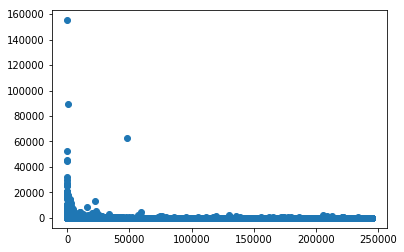

In [13]:
#plotting the points to decide how many points to take in our vocab
import matplotlib.pyplot as plt
plt.scatter(x,y)
#plt.axis([0,4000,0,60000])
plt.show()

In [15]:
#features contains the final set of 2000 words that will be our vocab
features=[]
for i in range(0,2000):
    features.append(d[i][1])
len(features)

2000

In [28]:
#simply adding the string filtered words in X if they are in our vocab i.e. *features*
#here j is the row index
def addToX(filtered,features,j,X):
    for s in filtered:
        if s in features:
            id= features.index(s)
            X[j][id]= X[j][id]+1
    return X

In [ ]:
#Again for each file in files
#I am simply reading the file and 
#removing stopwords and punctuation
def file_to_X(files,X,features,root,j):
    
    for f in files:
        path= root+'/'+f
        fle= open(path,'r')
        st= fle.read()
        strng=tokenizer.tokenize(st)
        filtrd = [w for w in strng if not w in stop_words]
        
        #Then I am adding the final list of words to X
        X=addToX(filtrd,features,j,X)
        #this is to keep track of the row nmber in X
        j=j+1
        #print(X.shape, x.shape)
    return X

In [59]:
#making our data array
def setIntoXForm(X, features):
    #i is simply to keep track on which class
    i=-1    
    #traversing the files directory
    for root, dirs, files in os.walk("./", topdown=True):
        #I have done this because I have saved this project file
        #in the same directory where all these text files are stored
        #so for once *files* will contain a single file i.e. this ipynb file
        #so to avoid this file I have done this
        if len(files)==1:
            continue
        
        i+=1
        X=file_to_X(files,X,features,root,1000*i)
    return X

In [44]:
#initialising data array and then calling setIntoXForm function
data= np.zeros([20000,2000])
data= setIntoXForm(data, features)

In [47]:
#Y is the output array
Y= np.zeros(20000)

In [48]:
#Y contains 1000 1's, 1000 2's upto.... 1000 19's just to represent the output classes
for i in range(20):
    for j in range(1000):
        Y[(i*1000)+j]=i

In [81]:
X_train, X_test, Y_train, Y_test= model_selection.train_test_split(data, Y)

In [83]:
X_train.shape, X_test.shape
n= X_train.shape[1]

In [172]:
X_train[Y_train==0].shape

(753, 2000)

In [194]:
#Creating the vocab dictionary 
vocab={}
classes= [x for x in range(0,20)]
#Traversing in all classes from 0 to 19
for c in classes:
    vocab[c]={}
    #Taking out the rows that belong to class c
    X_x= X_train[Y_train==c]
    vocab[c]["total"]= X_x.sum()
    #print(vocab[c]["total"], X_x.sum())
    #For the class c traversing in all the features and computing the values
    for f in range(len(features)):   
        vocab[c][f]= X_x[:,f].sum()

In [251]:
#Traversing on all the features and adding the log probabilities
def find_prob(X,c):
    p=0
    total_features= len(features)
    #Looping over all the features and adding the log probablities of each feature
    #probabilty of each feature will be that word count in that class divided by total word count
    #also included laplace correction
    for f in range(total_features):
        #Mulitiplying X[f] for more accurate results
        #No need to check whether X[f] is 0 or not as for zero , the whole probability will be zero
        p=p+ X[f]*np.log((vocab[c][f]+1)/(vocab[c]["total"]+total_features))
    return p

In [229]:
#For a given row in X_test finding the maximum probability among all the classes
def predict_X(X):
    #initialising max_prb with a minimum value
    max_prb= -sys.maxsize -1
    #i will store the result
    i=-1
    for c in classes:
        prob= find_prob(X,c)
        if prob>max_prb:
            max_prb=prob
            i= c
    return i

In [118]:
#For all the test points calculating y-predicted
def pred(X_test):
    y_pred=np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        y_pred[i]= predict_X(X_test[i])
    return y_pred

In [263]:
y_pred= pred(X_test)
y_pred

array([4., 8., 0., ..., 7., 3., 7.])

In [265]:
#Print the classification Report of predicted results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

[[189   0   0   0   0   0   2   5   4   1   0   0   2   3   1   0   1   1
    0  38]
 [  0 185   0  16  24   4   8   1   0   0   0   2   7   3   0   0   0   0
    0   0]
 [  0  24  14 135  21  42   9   3   0   0   0   0  11   2   0   0   0   0
    0   0]
 [  0   2   0 221  18   1   6   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   4   1  12 231   1   6   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0  26   1  13   8 205   3   2   0   0   0   1   6   0   3   0   0   1
    0   0]
 [  0   1   0   1   4   0 206   8   2   1   0   0   3   0   0   0   0   0
    0   1]
 [  0   0   0   1   1   0  10 227   9   1   0   0   8   0   0   0   0   0
    0   0]
 [  0   1   0   0   0   0   5   8 236   1   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   1   3   7 214   8   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   1   0   1   6   4  50 187   0   1   0   1   0   0   0
    1   0]
 [  1   0   0   1   0   2   0   0   0   0   0 248   8   3   0   0

In [266]:
#making an object of inbuilt multinomial naive bayes
#an fitting our data
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [267]:
#storing the predicted results in Y_pred_inbuilt
Y_pred_inbuilt= clf.predict(X_test)
Y_pred_inbuilt[0:11]

array([ 4.,  8.,  0., 17.,  3.,  4., 11.,  7., 19., 17., 11.])

In [268]:
clf.score(X_test, Y_test)

0.8022

In [269]:
print(confusion_matrix(Y_test, Y_pred_inbuilt))
print(classification_report(Y_test, Y_pred_inbuilt))

[[189   0   0   0   0   0   2   5   4   1   0   0   2   3   1   0   1   1
    0  38]
 [  0 185   0  16  24   4   8   1   0   0   0   2   7   3   0   0   0   0
    0   0]
 [  0  24  14 135  21  42   9   3   0   0   0   0  11   2   0   0   0   0
    0   0]
 [  0   2   0 221  18   1   6   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   4   1  12 231   1   6   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0  26   1  13   8 205   3   2   0   0   0   1   6   0   3   0   0   1
    0   0]
 [  0   1   0   1   4   0 206   8   2   1   0   0   3   0   0   0   0   0
    0   1]
 [  0   0   0   1   1   0  10 227   9   1   0   0   8   0   0   0   0   0
    0   0]
 [  0   1   0   0   0   0   5   8 236   1   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   1   3   7 214   8   0   0   0   1   0   0   0
    0   0]
 [  0   0   0   0   1   0   1   6   4  51 186   0   1   0   1   0   0   0
    1   0]
 [  1   0   0   1   0   2   0   0   0   0   0 248   8   3   0   0